In [1]:
%matplotlib inline

import numpy as np
import torch as t
import matplotlib.pyplot as plt


# Preamble

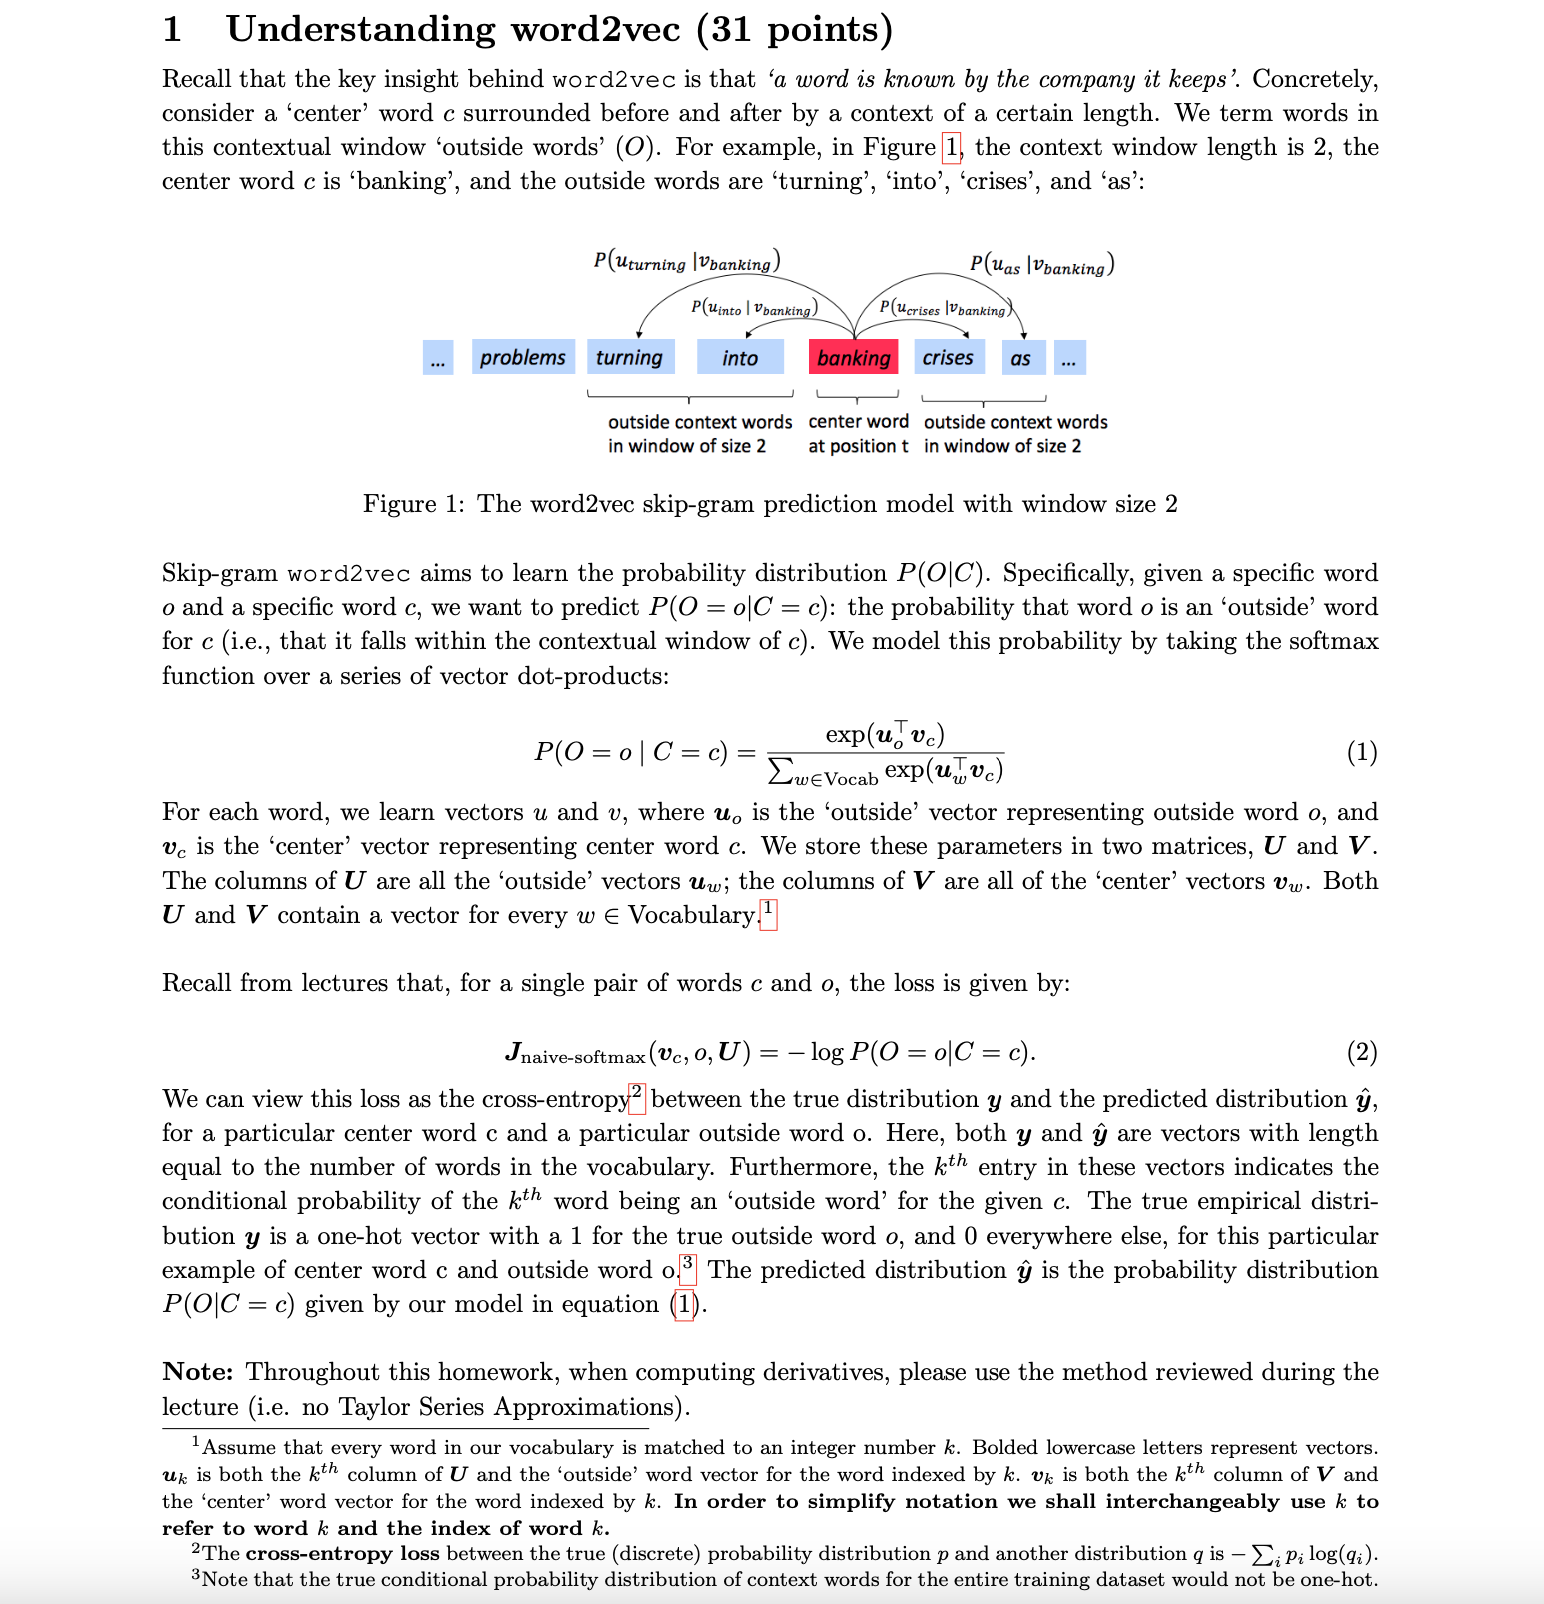

# Part 1 Questions

## (a)
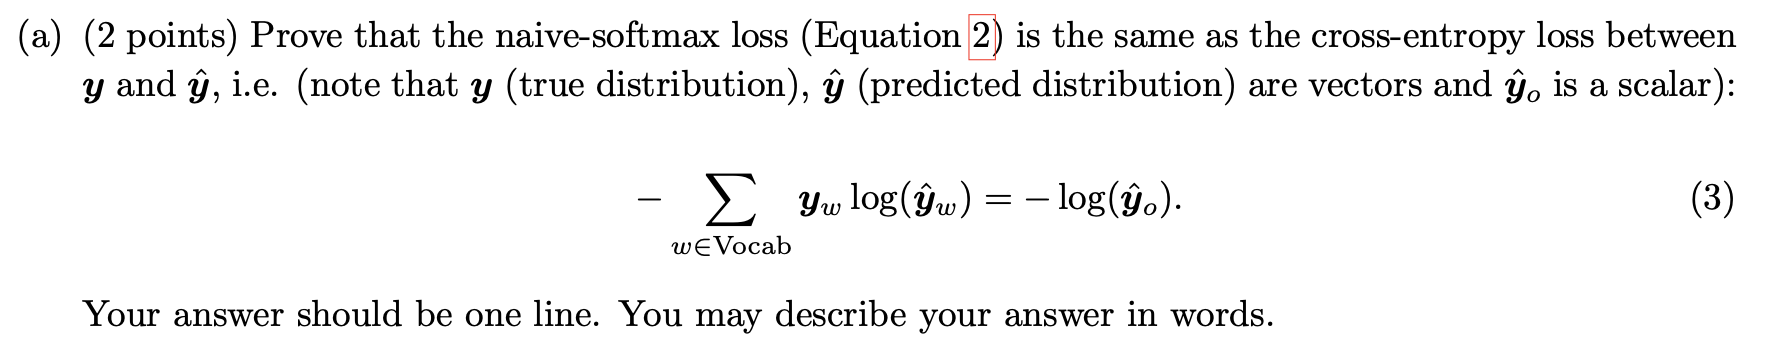

Eqn (2) is $J = -\log P(o|c)$, while cross-entropy is $-\sum_i p_i \log (q_i)$. Since $p_i$ is one-hot, taking the sum over $i$ is equal to taking just $-\log(q_i)$ at the observed value of $i$, which is exactly the expression from eq (2) taking $q_i = P(o|c)$.

## (b)
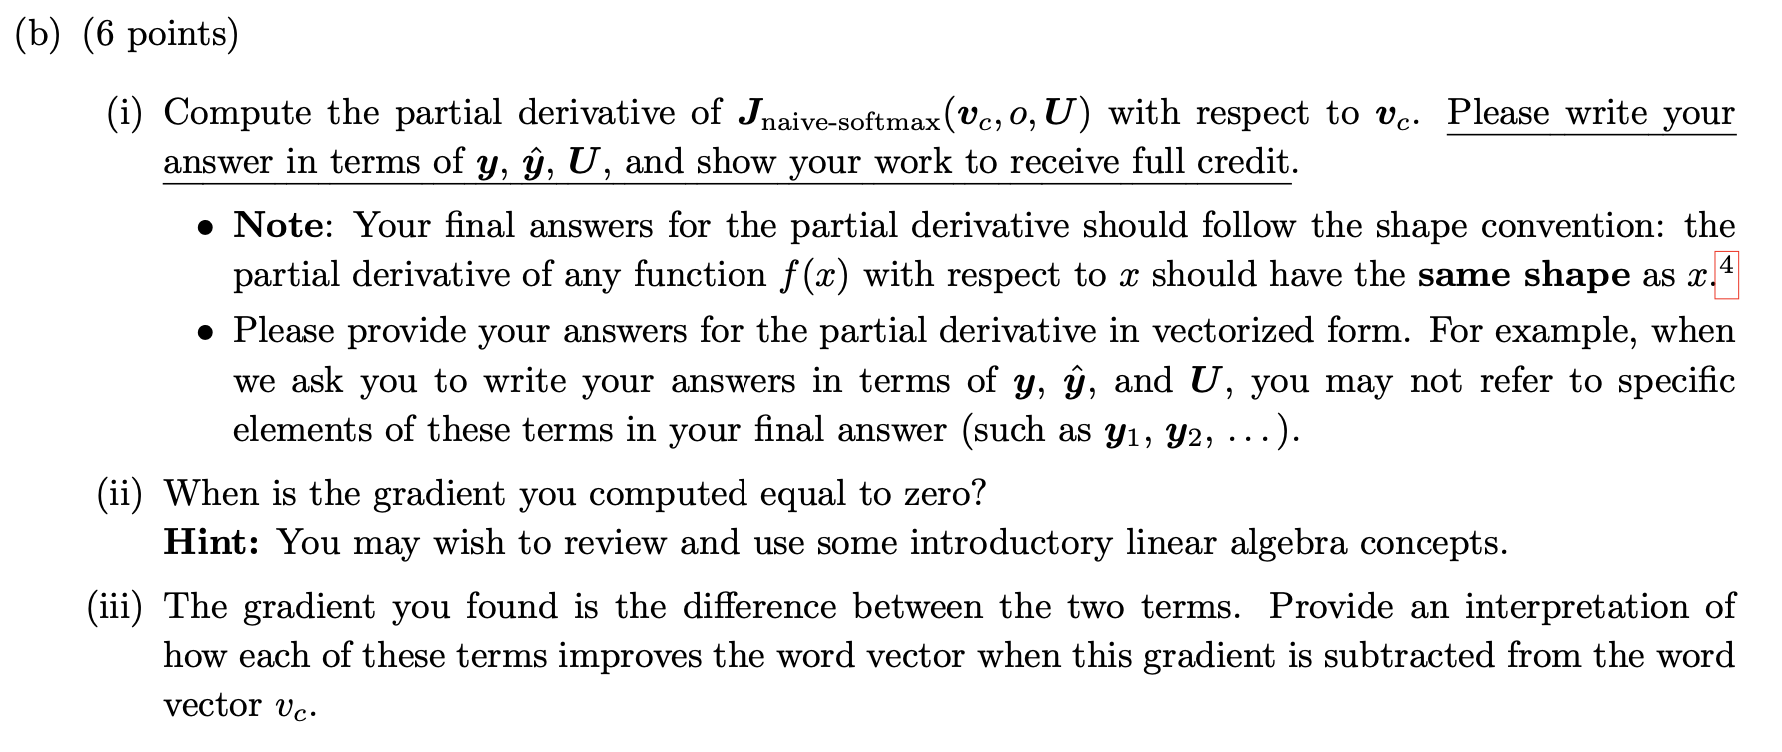

(i) This was derived in the lecture notes, but not in this format.

$\frac{\partial}{\partial \mathbf{v}_c}-\log(p(o|c)) = -U_o + \sum_x p(x|c) U_x$,

where subscripts indicate "index the $U$ matrix at the index of the center ($c$) or outside ($o$) word.

(ii) This is equal to zero when 

$U_o = \sum_x p(x|c) U_x$,

or when 

$1 = \sum_x p(x|c) \frac{U_o^T U_x}{||U_o||_x^2}$.

So basically it's the sum of the cosine similarity times the probability summed over every vector. I feel like there's something more subtle here that I'm missing.

(iii) We update with gradient descent, so $v_{c}^{i+1} = v_{c}^{i} - \alpha \frac{\partial J}{\partial v_c^i}$

The first term is simple -- it just adds the current observed word vector to $v_c$, increasing the probability of the center word happening when this observed word is in the context.

The second word pushes the gradient away from words that aren't observed that have a high probability of occurring. So if the model things word X should occur a lot, but it keeps not seeing it, then $v_c$ will point less in the direction of $U_X$ each iteration.

## (c) 
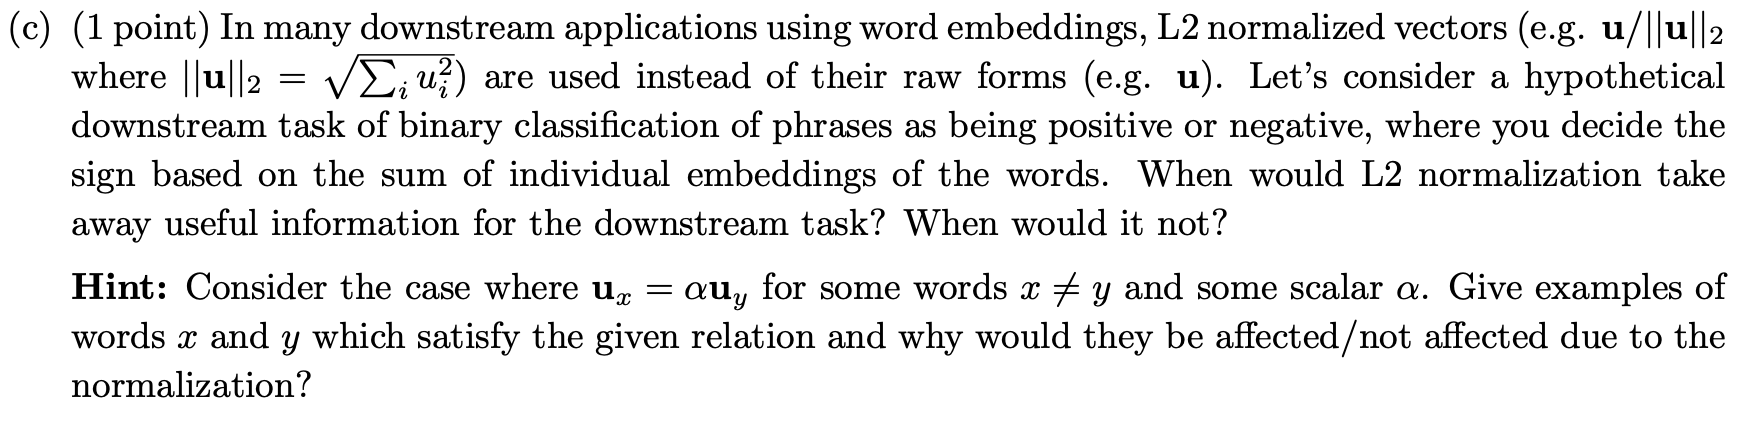

Two words that basically mean the same thing but with different severities would be negatively affected. For example, "dislike" and "hate" probably point in a similar direction (e.g., have the same normalized unit vector), but "hate" is a much stronger sentiment. The choice of normalizing these words would lose some information.

For words that are orthogonal, or that point away from the sentiment direction, this normalization shouldn't matter.

## (d) 
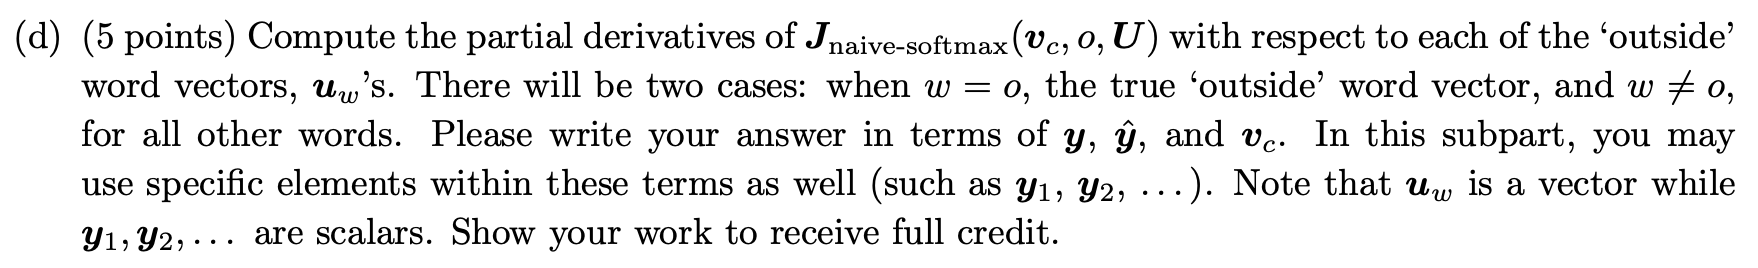

$\frac{\partial J_{\rm naive-softmax}}{\partial u_o} = 0$, as shown here:

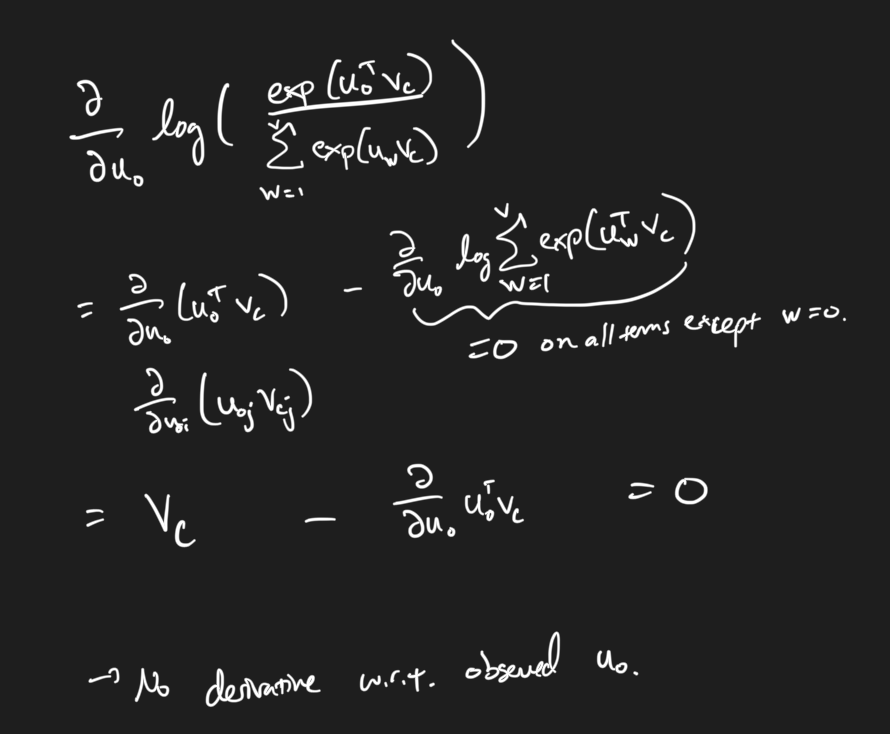

$\frac{\partial J_{\rm naive-softmax}}{\partial u_w} = -v_c$, as shown here:

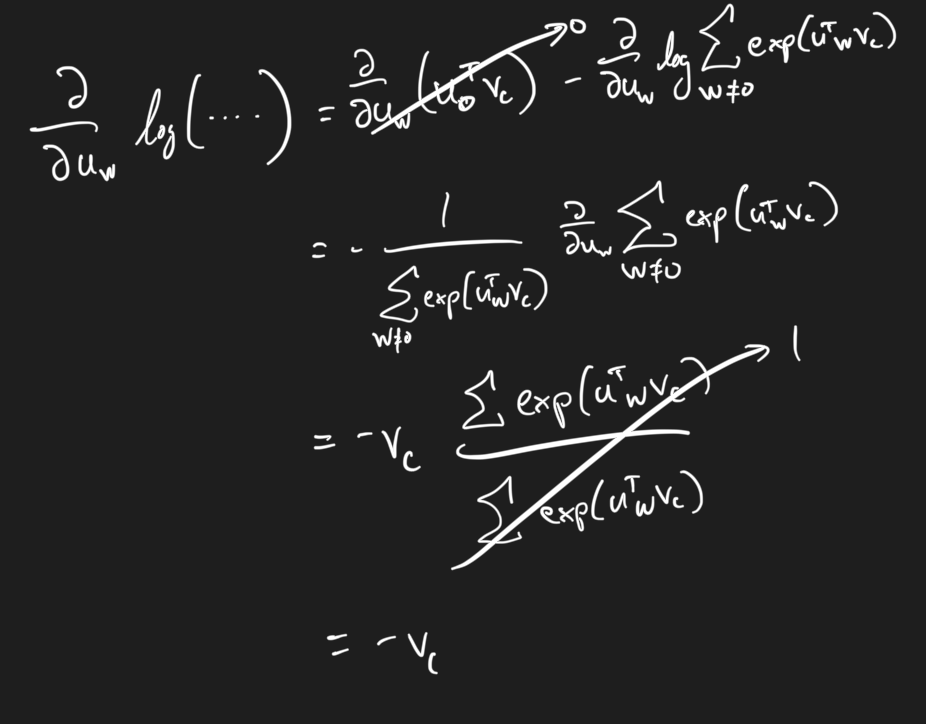

## (e)

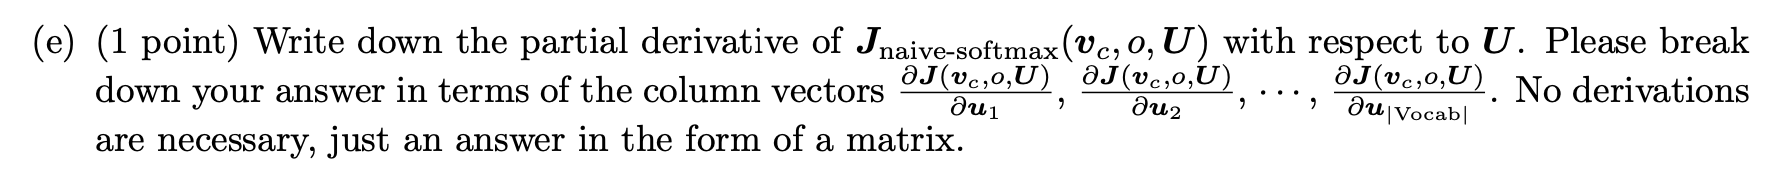

$\frac{\partial J}{\partial u_i} = - \left[v_c, v_c, \cdots, v_c, 0, v_c, \cdots v_c\right]$

(f)
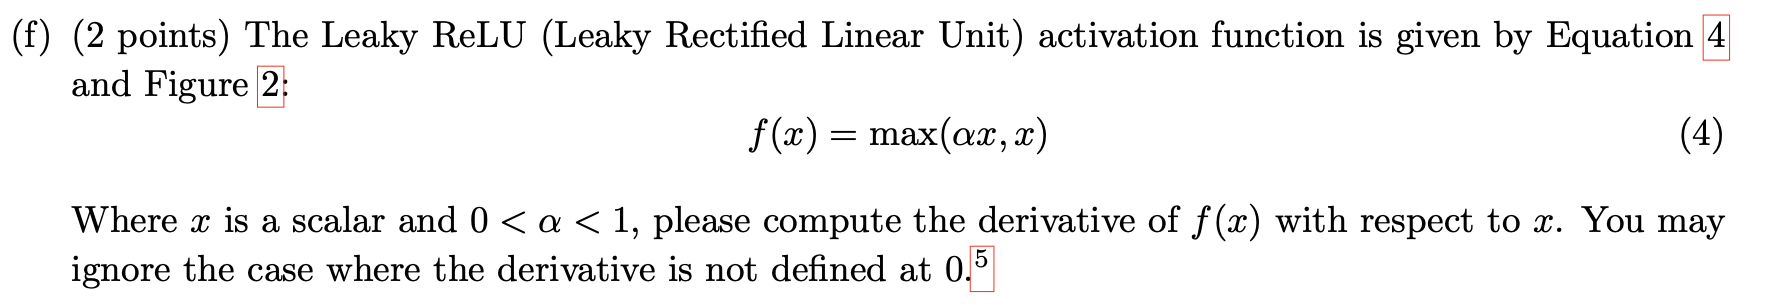
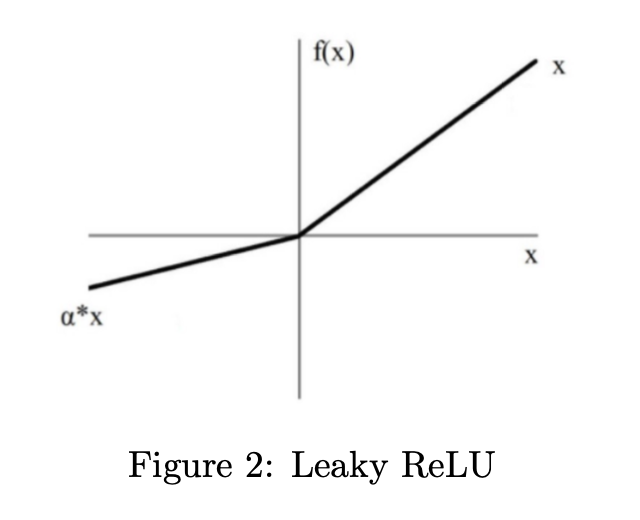

$f(x) = \begin{cases}\alpha x & x < 0 \\ x & x \geq 0\end{cases}$

so $\partial f / \partial x = \begin{cases}\alpha & x < 0 \\ 1 & x \geq 0\end{cases}$

(g)
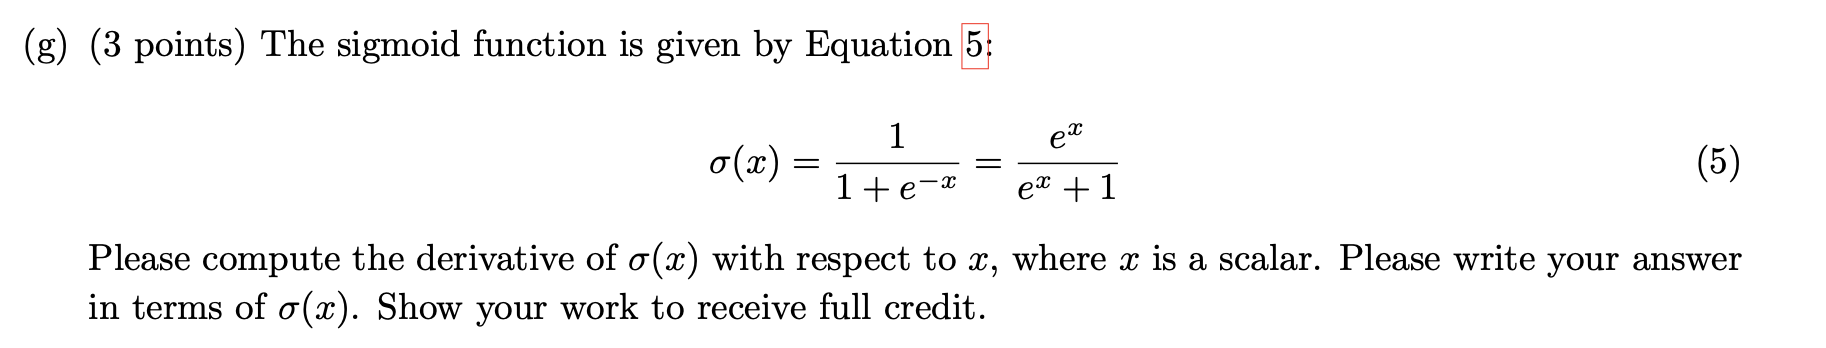

$\frac{\partial}{\partial x} \frac{e^{x}}{e^{x} + 1} = \frac{1}{e^{x} + 1}\frac{\partial}{\partial x} e^x + e^x \frac{\partial}{\partial x} \frac{1}{e^{x} + 1} = \sigma(x) + e^x - \frac{1}{(1 + e^x)^2} e^x = \sigma(x) - \sigma(x)^2$

(h)
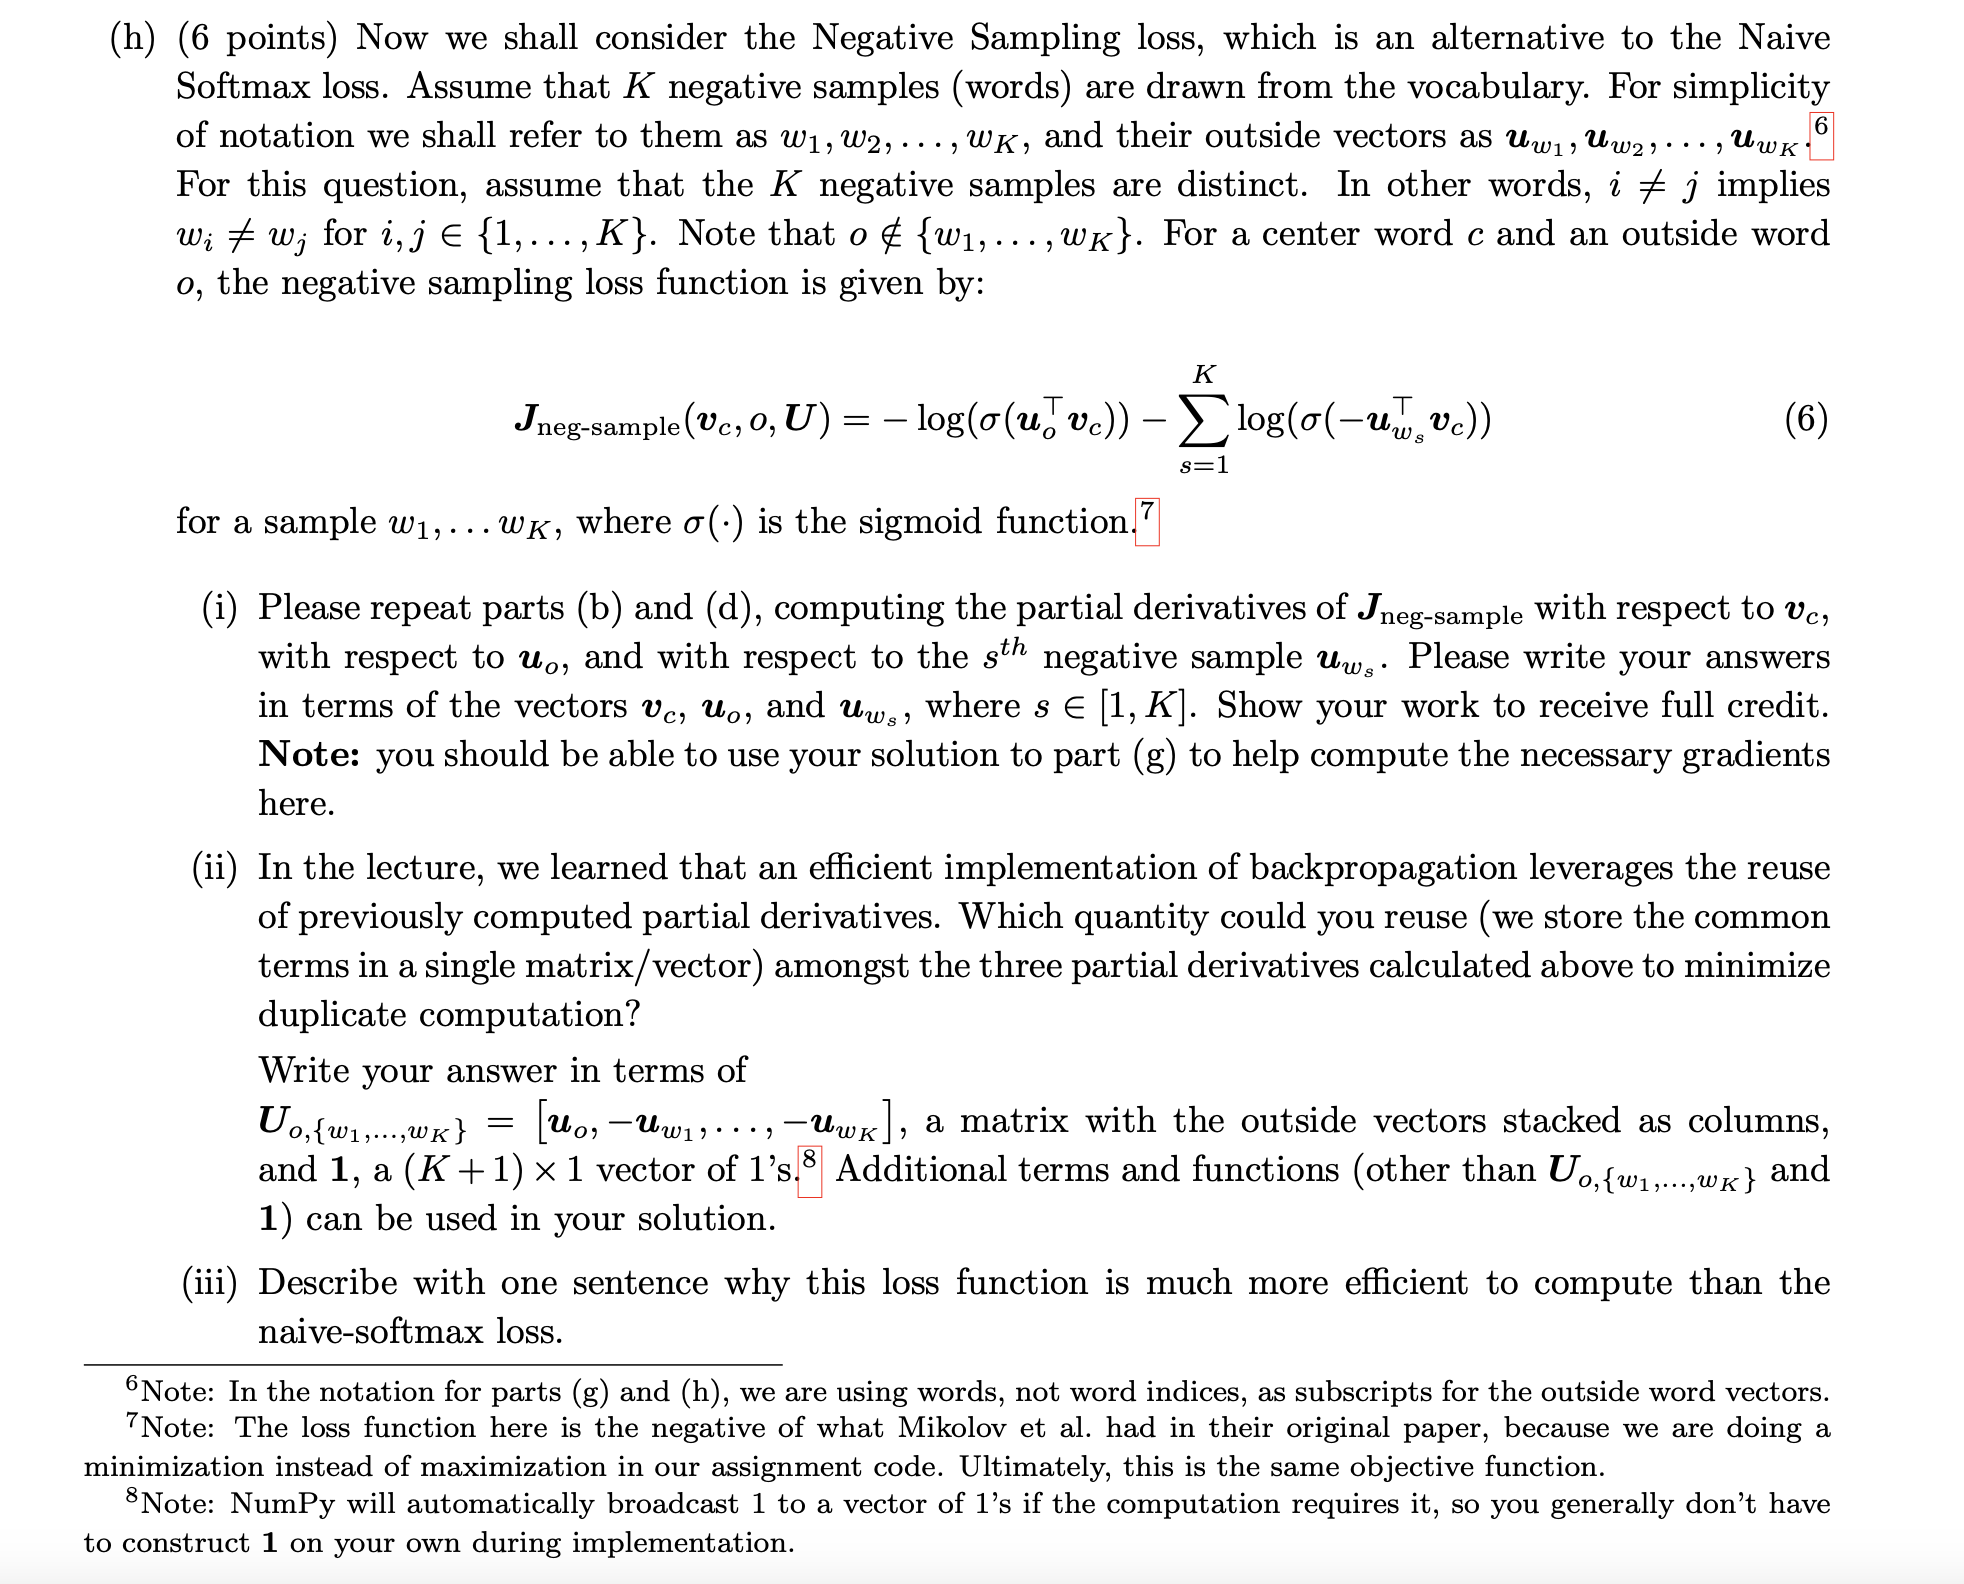
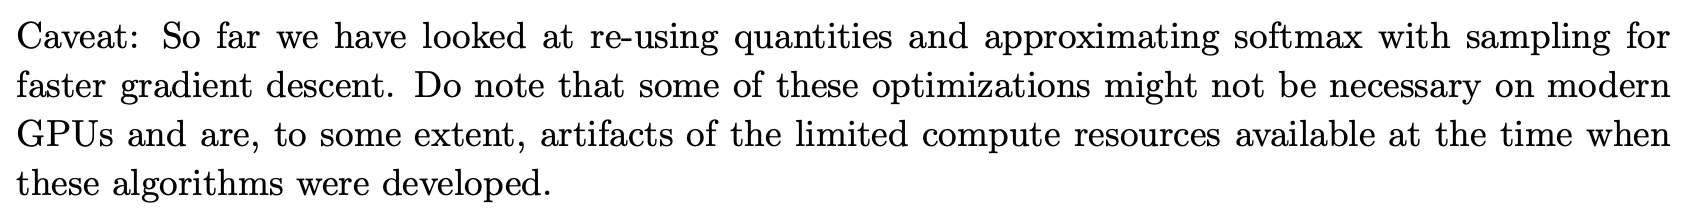

(i)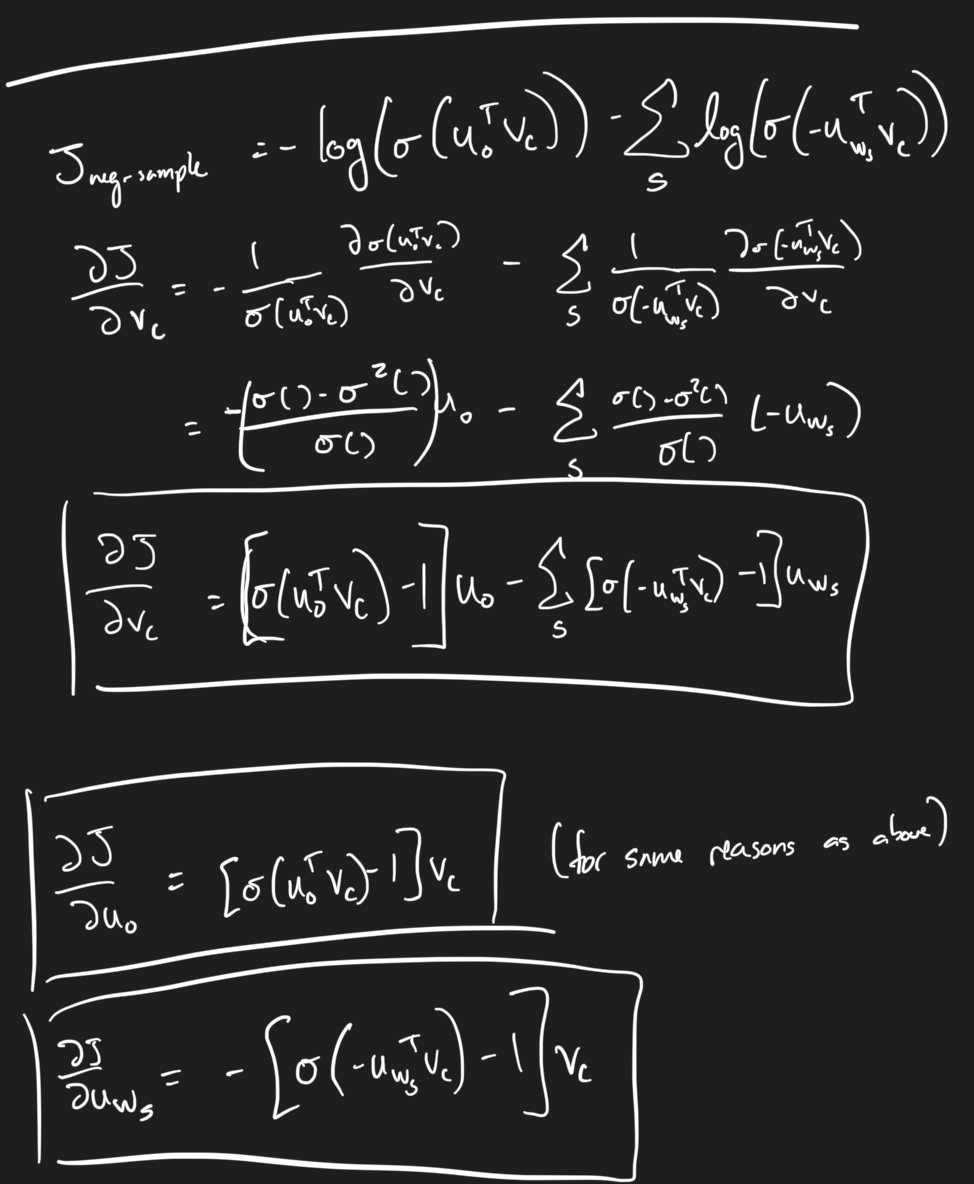

(ii) We reuse the $[\sigma(u_o^T v_c) - 1]$ term and each of the $[\sigma(-u_{w_s}^T v_c) - 1]$ terms, so those should be stored.

(iii) The naive softmax has slightly cleaner forms of the derivatives but they backprop over every vector in the vocab instead of this subset K.

(i)
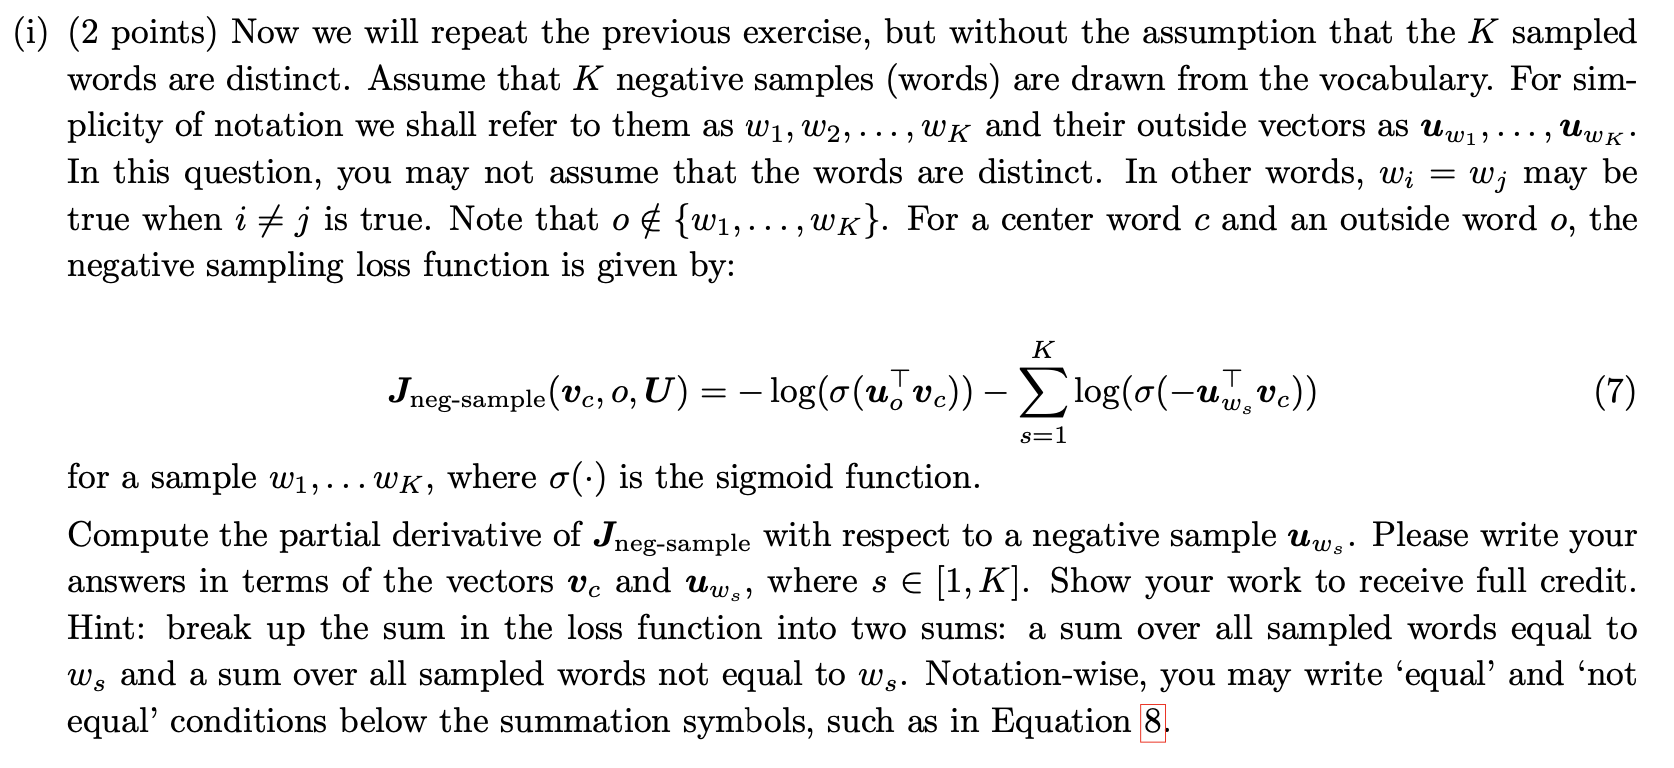

I'll just say verbally: we're going to have an extra scalar multiplier in front of the derivative which is equal to the number of times $w_s$ occurred in k. If it occurs once, we get the same answer as before. If it occurs twice, we multiply our previous answer by 2. And so on.

(j)
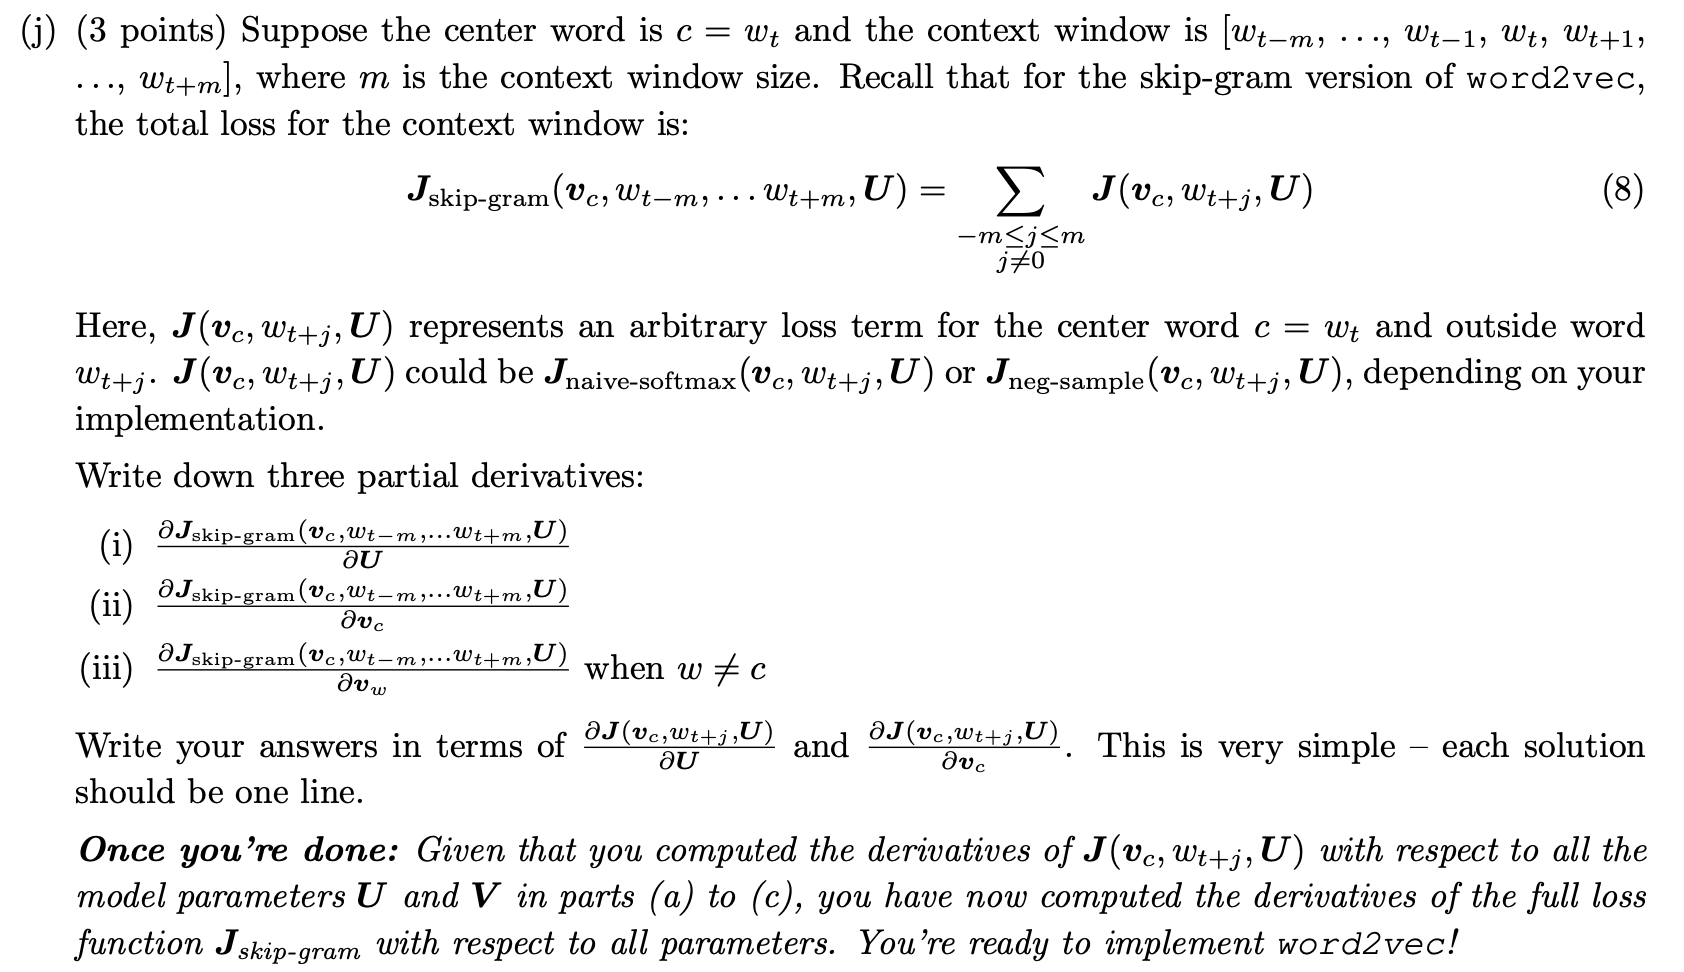

(i) and (ii) -- You literally just take the partial derivative inside of the sum and you're good to go.

(iii) - This is zero.

# Implementing word2vec

The assignment calls for this to be done manually, but I'm going to do it in pytorch.

In [27]:
from datasets import load_dataset
from tqdm.notebook import tqdm

sst = load_dataset("stanfordnlp/sst2")

In [37]:
from tokenizers import decoders, models, normalizers, pre_tokenizers, processors, trainers, Tokenizer

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()

#Test
test_str = sst["train"][0]["sentence"]
print(test_str)
print(tokenizer.pre_tokenizer.pre_tokenize_str(test_str))

hide new secretions from the parental units 
[('hide', (0, 4)), ('new', (5, 8)), ('secretions', (9, 19)), ('from', (20, 24)), ('the', (25, 28)), ('parental', (29, 37)), ('units', (38, 43))]


In [38]:
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.WordPieceTrainer(vocab_size=500000, special_tokens=special_tokens)

In [39]:
tokenizer.train_from_iterator(sst["train"]["sentence"], trainer=trainer)

In [41]:
print(tokenizer.get_vocab())
cls_token_id = tokenizer.token_to_id("[CLS]")
sep_token_id = tokenizer.token_to_id("[SEP]")
print(cls_token_id, sep_token_id)

{'##born': 10606, '##gh': 142, 'kennedy': 11152, 'boat': 5552, 'opportunities': 9733, '##icking': 2895, 'degraded': 13968, '##uracy': 10003, 'preferably': 13854, 'goal': 19596, 'unrelenting': 12818, 'skateboarder': 20108, 'pilot': 6837, 'overplay': 10730, 'reese': 19481, 'uglier': 16026, 'several': 2349, 'famuy': 15837, 'nad': 19354, 'unintentionally': 6376, '##esar': 16866, 'pages': 13074, 'indeed': 4826, 'sober': 3936, 'thorough': 1780, 'turks': 16146, 'dungeons': 17910, 'resourceful': 4327, 'why': 1078, 'cable': 6196, 'controlled': 17509, 'freakshow': 10974, 'devotees': 10436, 'lesb': 14157, 'outlandish': 12968, 'scientific': 15048, '##rest': 20329, 'collision': 7202, '##kemon': 5133, 'conceit': 9220, '##irk': 7092, 'bitten': 8187, 'pred': 833, 'stam': 9516, 'richness': 8344, 'passionate': 3850, 'humming': 7658, '##theaded': 16501, '##ield': 2548, 'absurdity': 3951, 'forages': 20377, 'wastes': 8385, 'copmovieland': 20208, '##apeutic': 17621, '##ysitter': 18554, 'bands': 7564, '##vio

In [42]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[CLS]:0 $A:0 [SEP]:0",
    pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", cls_token_id),
        ("[SEP]", sep_token_id),
    ],
)

In [46]:
for i in range(100):
    print(tokenizer.encode(sst["train"][i]["sentence"]).tokens)

['[CLS]', 'hide', 'new', 'secretions', 'from', 'the', 'parental', 'units', '[SEP]']
['[CLS]', 'contains', 'no', 'wit', ',', 'only', 'labored', 'gags', '[SEP]']
['[CLS]', 'that', 'loves', 'its', 'characters', 'and', 'communicates', 'something', 'rather', 'beautiful', 'about', 'human', 'nature', '[SEP]']
['[CLS]', 'remains', 'utterly', 'satisfied', 'to', 'remain', 'the', 'same', 'throughout', '[SEP]']
['[CLS]', 'on', 'the', 'worst', 'revenge', '-', 'of', '-', 'the', '-', 'nerds', 'cliches', 'the', 'filmmakers', 'could', 'dredge', 'up', '[SEP]']
['[CLS]', 'that', "'", 's', 'far', 'too', 'tragic', 'to', 'merit', 'such', 'superficial', 'treatment', '[SEP]']
['[CLS]', 'demonstrates', 'that', 'the', 'director', 'of', 'such', 'hollywood', 'blockbusters', 'as', 'patriot', 'games', 'can', 'still', 'turn', 'out', 'a', 'small', ',', 'personal', 'film', 'with', 'an', 'emotional', 'wallop', '.', '[SEP]']
['[CLS]', 'of', 'saucy', '[SEP]']
['[CLS]', 'a', 'depressed', 'fifteen', '-', 'year', '-', 'old'

In [47]:
print('vocab size:', tokenizer.get_vocab_size())


vocab size: 20832
